In [1]:
import pickle
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import random
import itertools
import functools
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import gudhi.wasserstein as wasserstein
from torch_topological import nn as topnn

from advtopo import utils

In [2]:
dirPath = "./data/"

# We only use L from here, the one-hot encoded labels
diags_dict, F, L = utils.load_data("ORBIT5K", path_dataset=dirPath)

# D is preprocessed as in Perslay
with open(dirPath + 'processed_D.pkl', 'rb') as f:
    D = pickle.load(f)

/home/andrea/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Diagrams

Below we show some summary statistics based on the barcodes/persistence diagrams. E.g. if all barcodes contain 500 bars, what is the distribution of birth and death values, etc.

In [3]:
print(D[0].shape)
print(D[1].shape)

(5000, 500, 3)
(5000, 500, 3)


In [4]:
all_h0_deaths = D[0][:,:,1].flatten()
all_h1_births = D[1][:,:,0].flatten()
all_h1_deaths = D[1][:,:,1].flatten()

In [5]:
pd.Series(all_h0_deaths).describe()
print("num 0:", (all_h0_deaths==0).sum()/all_h0_deaths.shape[0])

num 0: 0.0


In [6]:
pd.Series(all_h1_births).describe()
print("num 0:", (all_h1_births==0).sum()/all_h1_births.shape[0])

num 0: 0.0162128


In [7]:
pd.Series(all_h1_deaths).describe()
print("num 0:", (all_h1_deaths==0).sum()/all_h1_deaths.shape[0])

num 0: 0.0162124


Average number of non-zero bars. Due to a few barcodes having just 1 bar. All other have 500 bars.

491.8938


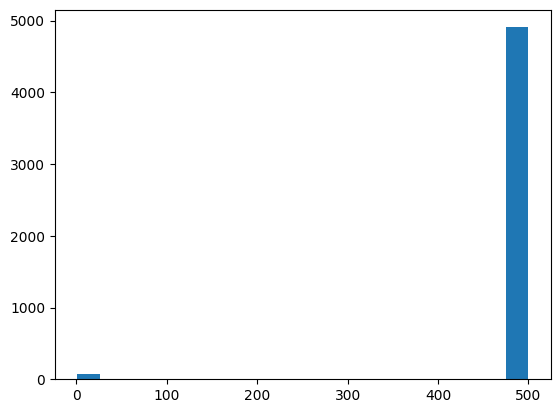

In [8]:
print(np.mean([(D[1][i, :, 1]>0).sum() for i in range(5000)]))

plt.hist(np.array([(D[1][i, :, 1]>0).sum() for i in range(5000)]), bins=20)
plt.show()

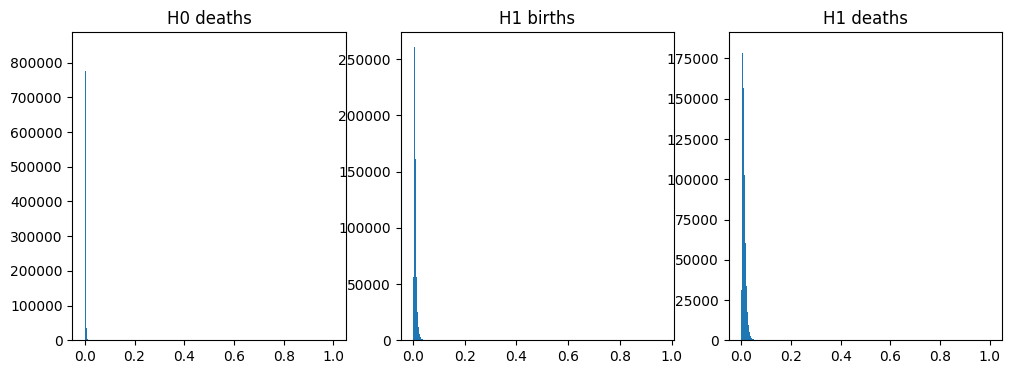

In [9]:
n_bins = 1000
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(all_h0_deaths, bins=n_bins)
plt.title("H0 deaths")
plt.subplot(132)
plt.hist(all_h1_births, bins=n_bins)
plt.title("H1 births")
plt.subplot(133)
plt.hist(all_h1_deaths, bins=n_bins)
plt.title("H1 deaths")
plt.show()

### Labels

In [12]:
L

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

We compute mean distances between classes, based on samples because distance computations are expensive for Wasserstein.

In [13]:
order = 1 # the "p" in Wasserstein distance
H = 1 # the homology dimension

iters = 500 # number of iterations to estimate the Wasserstein distance
dist_mat = np.zeros((5, 5))

for class1 in range(5):
  for class2 in range(5):

    dists = []
    inds_class1 = np.where(L[:,class1]==1)[0]
    inds_class2 = np.where(L[:,class2]==1)[0]

    rand1 = np.random.choice(inds_class1, size=iters)
    rand2 = np.random.choice(inds_class2, size=iters)

    for i in range(iters):

      sample_class1 = D[H][rand1[i], :, :2]
      sample_class2 = D[H][rand2[i], :, :2]

      dist = wasserstein.wasserstein_distance(sample_class1, sample_class2, matching=False, order=order, internal_p=order)
      dists.append(dist)

    dist_mat[class1, class2] = np.array(dists).mean()

In [14]:
np.round(dist_mat, 5)

array([[0.65682, 0.6174 , 0.64679, 0.86542, 0.81843],
       [0.61831, 0.41129, 0.47298, 0.72995, 0.75117],
       [0.6328 , 0.47594, 0.46502, 0.66816, 0.71295],
       [0.84779, 0.73406, 0.64926, 0.54976, 0.69375],
       [0.80511, 0.75488, 0.68615, 0.71016, 0.65711]])